In [76]:
# to suppress futurewarnings caused by pandas and other libraries not updating their numpy interface codes
# apparently has to come before these import, so leave this on top
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
import numpy as np

In [80]:
import matplotlib.pyplot as plt

In [26]:
import pymc3 as pm

In [54]:
import scipy.stats as stats

In [23]:
%matplotlib inline

# Chapter 4
* linear regression = family of simple statistical models learning abou mean + variance of some measure, using additive combination of other measure
* descriptive model corresponding to many process models
* likely to make mistakes if their structure read too literally
* this chapter: lin. regre. as bayesian procedure

## 4.1. Why normal distributions are normal
* sum of binomial events will be distributed Gaussian (football field example)

### 4.1.1. Normal by addition

In [68]:
# code 4.1
pos = [np.random.uniform(low=-1, high=1, size=16).sum() for _ in range(1000)]

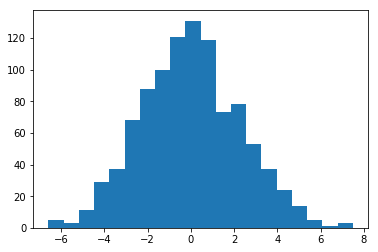

In [69]:
plt.hist(pos, bins=20);

* any process that adds together random values from the same distribution converges to normal
* conceptual help: each value is deviation from mean of drawing distribution. the more elements in sum of draws, the higher the chance that positive deviations cancel out with negative deviations, large ones with large ones etc, so the higher the chance we'll get something close to the mean out of the sum. there are more ways to realize the mean as a sum of draws than there are ways to realize extreme values
* works for nearly all underlying distrbutions

### 4.1.2. Normal by multiplication

In [71]:
# code 4.2
(1 + np.random.uniform(0, 0.1, 12)).prod()

1.8043404442938615

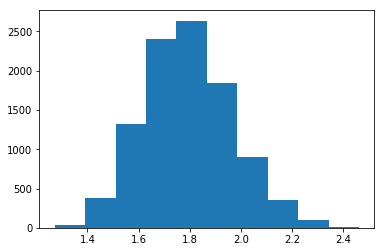

In [73]:
# code 4.3
growth = [(1 + np.random.uniform(0, 0.1, 12)).prod() for _ in range(10000)]
plt.hist(growth);

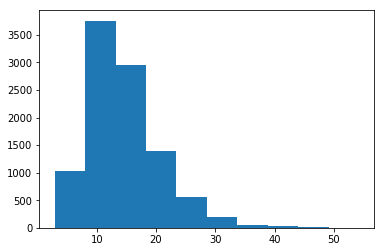

In [76]:
# code 4.4
big = [(1 + np.random.uniform(0, 0.5, 12)).prod() for _ in range(10000)]
plt.hist(big);

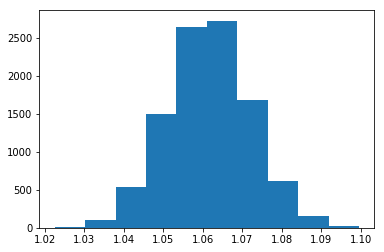

In [77]:
small = [(1 + np.random.uniform(0, 0.01, 12)).prod() for _ in range(10000)]
plt.hist(small);

* learned: multiplication of small numbers is roughly like addition, leads to Gaussian. the smaller the numbers, the better this works
* even more effects resulting in Gaussian

### 4.1.3. Normal by log-multiplication
* log of product of large deviations also leads to Gaussian, as log of product = sum of logs
* measurement scales are arbitrary, so 'log'-ing something is fair transformation

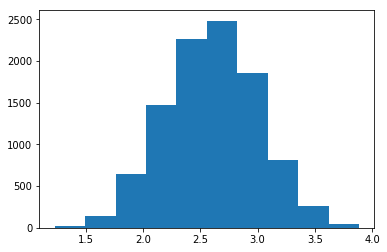

In [79]:
log_big = [np.log((1 + np.random.uniform(0, 0.5, 12)).prod()) for _ in range(10000)]
plt.hist(log_big);

### 4.1.4. Using Gaussian Distributions
* ontological justification for using Gaussian: world is full of it (approximately), b/c many processes add together random fluctuations
* consequence: cannot infer underlying process from model. can still build useful model
* other patterns also frequent and useful: exponential, gamma, Poisson, ...; all members of ***Exponential Family***
* epistemological justification: if we only want to make statements about mean and finite variance of some distribution then Gaussian is most general, does not need any other assumptions
* Gaussian is least informative and least surprising
* based on ***information theory*** and **maximum entropy***, subjects of later chapters
* using a model does not mean swearing an oath to it
* ***overthinking: gaussian distribution***:
* characteristic shape given by exp(\mu-y^2), rest of formula for standardization
* Gaussian is continuous function = ***probability density**
* typically denoted 'p' or 'f'
* denotes ***rate of change in cumulative probability** thus can be higher than 1, whole distribution still needs to integrate to 1
* discrete probability distributions like binomial: ***probability mass**
* typically denoted 'Pr'
* need to sum to 1, so no value can be higher than 1

## 4.2. A language for describing models
* model description consists of the following parts
* define outcome variable, thing we wish to predict or understand
* for each of these: define likelihood distribution defining plausibility of individual data points. for linear regression: always gaussian
* define predictor variables, which we want to use to learn something about outcome variables
* define relationship between parameters of outcome likelihood distribution to predictor variables. by doing this, we have to define and list all parameters of the model
* for all of these model parameters: choose priors = initial information state of the model before seeing any data
* fundamentally, models describe ways that values of variabes can arise given values of other variables

### 4.2.1. re-describing globe tossing model
* w~Binomial(n,p)
* w~Uniform(0,1)
* count of water is distributed binomially with sample size n and probability p 
* by writing like this assumption clear: Binomial assumes tosses to be indenpendent, so we know that model overall assumes that samples are independent of each other
* "variablename ~ distribution" is ***stochaistic*** mapping. no instance of variable known with certainty, some values are more plausible than others but many are possible
* ***overthinking: from model definition to bayes' theorem***

In [103]:
w = 6
n = 9
p_grid = np.linspace(start = 0, stop = 1, num = 100)

In [104]:
posterior = stats.binom.pmf(w, n, p_grid) * stats.uniform.pdf(p_grid)
posterior = posterior / posterior.sum()

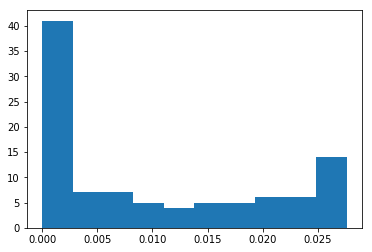

In [114]:
plt.hist(posterior);

***question***: this looks sort of weird? shouldn't 6 out of 9 lead to a much higher concentration around high values for p?

***question*** regarding outcome variable vers bayesian formulation. we define 'w' to be the outcome variable, so the thing we want to predict or understand. however, all the time before we were actually interested in inferring the value of 'p'. and in the bayesian formulation of the overthinking box, this also seems to be the case again. how do these two go together?

## 4.3. A Gaussian model of height
### 4.3.1. The data

In [2]:
import pandas as pd

In [120]:
# code 4.7
d = pd.read_csv('data/Howell1.csv', sep=';')

In [122]:
# code 4.8
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [124]:
# code 4.9
d.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

In [126]:
# 4.10
d2 = d[d.age >= 18]

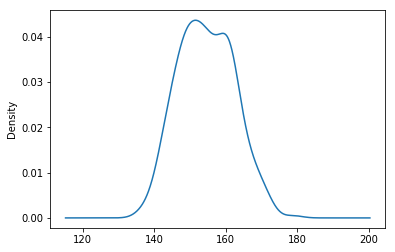

In [133]:
d2.height.plot(kind='density');

### 4.3.2. The model
* output plot (see above) suggest Gaussian as distribution for height var. but: 1) inspection can not always give good insight, could be mixture of multiple Gaussians etc and 2) Gaussian can be useful even if distr. looks different
* h_i = N(\mu, \sigma)
* note: index 'i' does not appear on righthand side, thus same distribution for all data points = i.i.d
* ***rethinking: iid***: independently and identically distributed. each data point has the same probability function. hardly ever true, e.g. heights within one family are probably correlated. however, not necessarily a problem. i.i.d. is epistemological assumption about uncertainty within the model, small-world. does not need to make claim about real world, i.e. does not imply ontological assumption (see E.T. Jaynes 'the mind fallacy', confusing epistemological with ontological claims). in ignorance of correlations: i.i.d. is most conservative, least informative, likely to be useful. {***Point I don't understand well***: de Finetti's Theorem about exchangeability and recognizing that multiple process models can lead to the same statistical model tell us that i.i.d. as an asssumption cannot be 'read too literally'}. Finally, some correlations just change order of data points, don't really affect shape of overall distributions, e.g. correllation between heights of sisters does not really impact Gaussian distribution of female height in general, so i.i.d. remains useful


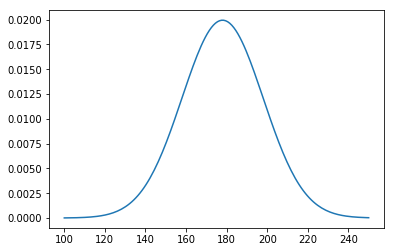

In [138]:
# 4.11
x = np.linspace(100, 250, num=150)
plt.plot(x, stats.norm.pdf(x, 178, 20));

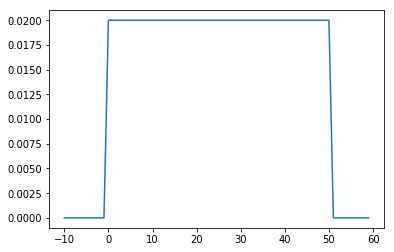

In [143]:
# 4.12
x = np.arange(-10, 60)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

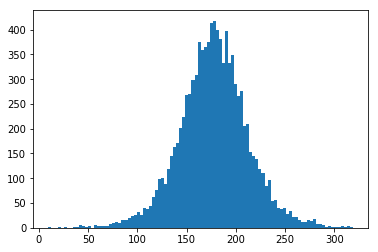

In [167]:
# 4.13
sample_mu = stats.norm.rvs(loc=178, scale=20, size=10000)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=10000)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
plt.hist(prior_h, bins=100);

* ***this should be a 'vaguely bell-shaped curve with thick tails'. this does not fit what i see?***

* ***overthinking: model definition to bayes' theorem again:*** 
Pr(\mu, \sigma) = \prod_i Normal(h_i | \mu, \sigma) * Normal(\mu| 178, 20) * Uniform(\sigma, 0, 50) / {same term integrated over \mu and \sigma}.

so: for each datum, multiply likelihood with priors for mu and sigma, normaly through evidence to get posterior probablity for joined distribution over mu and sigma

### 4.3.3. Grid approximation of the posterior distribution

In [279]:
# 4.14 dataframe version

In [281]:
mu_list = np.linspace(start = 140, stop = 160, num = 200)
sigma_list = np.linspace(start = 4, stop = 9, num = 200)
mugrid, sigmagrid = np.meshgrid(mu_list, sigma_list)

post = pd.DataFrame(data={'mu':mugrid.ravel(), 'sigma': sigmagrid.ravel()})

post['LL'] = post.apply(
        func=lambda row: np.sum(stats.norm.logpdf(d2.height, loc = row.mu, scale = row.sigma)),
        axis=1
)


post['prod'] = post.LL + stats.norm.logpdf(post.mu, loc = 178, scale = 20) + stats.uniform.logpdf(post.sigma, loc = 0, scale = 50)

post['prob'] = np.exp(post['prod'] - post['prod'].max())

In [314]:
post.head()

,mu,sigma,LL,prod,prob
0,140.000000,4.0,-3812.775755,-3822.407448,0.0
1,140.100503,4.0,-3780.611884,-3790.234043,0.0
2,140.201005,4.0,-3748.670231,-3758.282879,0.0
3,140.301508,4.0,-3716.950793,-3726.553958,0.0
4,140.402010,4.0,-3685.453573,-3695.047278,0.0


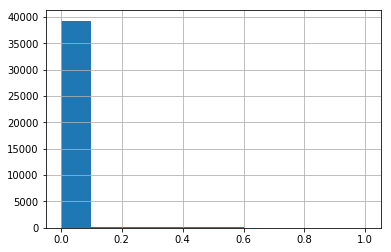

In [320]:
post['prob'].hist();

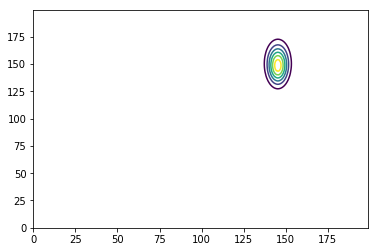

In [326]:
plt.contour(post['prob'].values.reshape((200, -1)));

In [226]:
import seaborn as sns

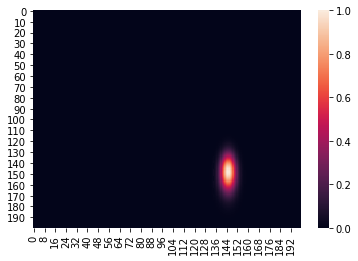

In [344]:
sns.heatmap(post['prob'].values.reshape((200, -1)));

side note, ***neat trick***: np.exp(post_prod) yields an array of 0s. np.exp(post_prod - post_prod.max()) yields non-zero numbers. those are not probabilities, but the are relative plausibilities, which is already super helpful

### 4.3.4. Sampling from the posterior

In [353]:
# 4.17
sample_rows = np.random.choice(np.arange(post.shape[0]), size=10000, replace=True, p=post['prob']/post['prob'].sum())
sample_mu = post['mu'].iloc[sample_rows]
sample_sigma = post['sigma'].iloc[sample_rows]

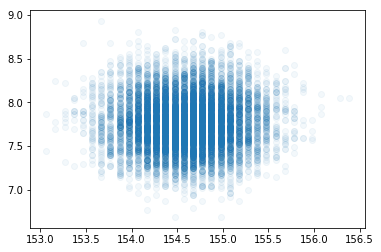

In [354]:
# 4.18
plt.scatter(sample_mu, sample_sigma, alpha=.05);

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


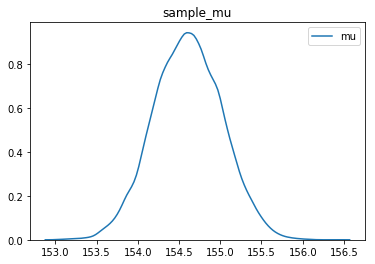

In [345]:
# 4.19
sns.kdeplot(sample_mu);
plt.title('sample_mu');

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


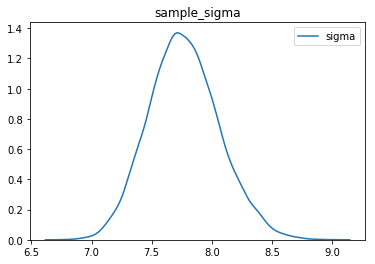

In [346]:
# 4.19
sns.kdeplot(sample_sigma);
plt.title('sample_sigma');

## for HDPI(data), i.e. code 4.20: look at PyMC3-translated examples to find right function

In [337]:
import pymc3 as pmc

In [341]:
# 4.20
print(pmc.hpd(sample_mu))
print(pmc.hpd(sample_sigma))

[153.66834171 155.27638191]
[7.24120603 8.3718593 ]


*** Overthinking: Sample size and the normality of σ’s posterior. ***

* gaussian approximation works well for mu, but not for sigma. intuition: variance can only be positive, so more uncertainty about how big it is as opposed to how small it is. effect: longer/thicker right tail
* following code illustrates this

In [348]:
# 4.21
d3 = d2.height.sample(n=20, random_state=42)

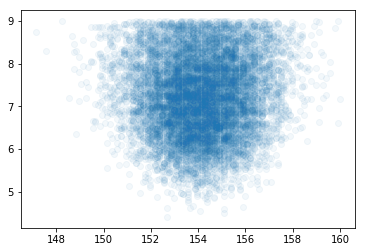

In [352]:
# 4.22
mu_list = np.linspace(start = 140, stop = 160, num = 200)
sigma_list = np.linspace(start = 4, stop = 9, num = 200)
mugrid, sigmagrid = np.meshgrid(mu_list, sigma_list)

post2 = pd.DataFrame(data={'mu':mugrid.ravel(), 'sigma': sigmagrid.ravel()})

post2['LL'] = post2.apply(
        func=lambda row: np.sum(stats.norm.logpdf(d3, loc = row.mu, scale = row.sigma)),
        axis=1
)


post2['prod'] = post2.LL + stats.norm.logpdf(post2.mu, loc = 178, scale = 20) + stats.uniform.logpdf(post2.sigma, loc = 0, scale = 50)

post2['prob'] = np.exp(post2['prod'] - post2['prod'].max())

sample2_rows = np.random.choice(np.arange(post2.shape[0]), size=10000, replace=True, p=post2['prob']/post2['prob'].sum())
sample2_mu = post2['mu'].iloc[sample2_rows]
sample2_sigma = post2['sigma'].iloc[sample2_rows]

plt.scatter(sample2_mu, sample2_sigma, alpha=.05);

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


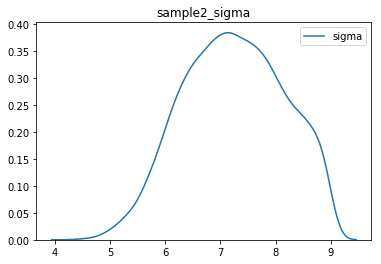

In [355]:
# 4.23
sns.kdeplot(sample2_sigma);
plt.title('sample2_sigma');

### 4.3.5. Fitting the model with map

* uses quadratic approximation "one of the great engines of applied statistics"
* fit's maximum a posteriori (map) estimate to find peak of posterior and curvature around it
* `map` function uses model definition to do hillclimbing on posterior
* however, note that following https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_04.ipynb we will use mcmc instead

In [3]:
# 4.24
d = pd.read_csv('data/Howell1.csv', sep=';')
d2 = d[d.age >= 18]

In [5]:
d2.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [6]:
# 4.25

In [28]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)

The authors of the PyMC3-translation of the book choose to [proceed with MCMC here](https://render.githubusercontent.com/view/ipynb?commit=311da5548a958574b9baf29646458871062284aa&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f616c6f637461766f6469612f537461746973746963616c2d52657468696e6b696e672d776974682d507974686f6e2d616e642d50794d43332f333131646135353438613935383537346239626166323936343634353838373130363232383461612f4368705f30342e6970796e62&nwo=aloctavodia%2FStatistical-Rethinking-with-Python-and-PyMC3&path=Chp_04.ipynb&repository_id=67766282&repository_type=Repository#Code-4.26) instead of doing a quadratic approximation like McElreath does. I'll try to stick closely to the original book instead.

I'll follow their MCMC approach anyway, so I don't have to wrestle with an unknown library to get quadratic approximations out, but it would be useful to actually learn about them more and also implement those

In [29]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 859.08draws/s] 
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


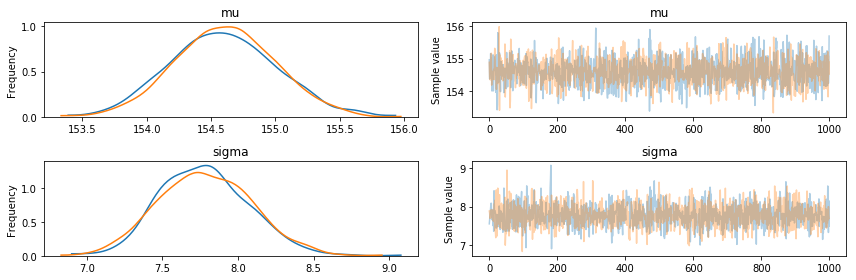

In [30]:
pm.traceplot(trace_4_1);

In [31]:
# Code 4.27
pm.summary(trace_4_1, alpha=.11).round(2)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
mu,154.60,0.4,0.01,153.98,155.25,2555.36,1.0
sigma,7.78,0.3,0.01,7.34,8.26,2127.51,1.0


* above is the fit model. numbers provide estimates of marginal distributions for parameters, meaning that the number reported for mu accounts for averaging over all plausibilities of sigma and vice versa.
* 89% as width for hpdi arbitrary width
* nearly the same output as for grid approx. this is to be expected when posterior is gaussian
* **overthinking: start values for quadratic approximation**: `rethinking` r package offers `map` routine for quadratic approximation. can be given explicit initialization values for hill climbing. default is to use samples from prio
* priors used were weak. how do things change for stronger prior? investigate by changing stddev for `mu` prior to 0.1 and inspect results

In [33]:
# Code 4.29
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu=178, sd=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_2 = pm.sample(1000, tune=1000)

pm.summary(trace_4_2, alpha=.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1176.46draws/s]
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
mu,177.86,0.10,0.00,177.69,178.00,1760.05,1.0
sigma,24.56,0.92,0.02,23.13,26.01,1815.65,1.0


* observations: value for `mu` nearly unaffected by data, remains at prior position. effect of strong prior. however, unexpected: posterior distribution of `sigma` also very different, even though only `mu` prior changed. explanation: marginal distrbution of `sigma` needs to change to accommodate changed distribution of `mu`. once model assumes that this is different the rest needs to be made to fit
* **overthinking: how strong is a prior?** if seeing prior as posterior of earlier inference: in this model easy to determine how much data would have been needed to be observed to create prior. sigma_post = 1/sqrt(n). thus n = 1/sigma_post^2. for sigma_post = 0.1 we compute n = 178. so would have needed to observe 178 data points with mean of 178 to create the previous prior. for weaker prior with stddev 20 would have only needed to observe 0.0025 data points, much weaker. also note that sigma_post = 1/sqrt(n) is same formula as for standard error of sampling distribution of the mean in non-bayesian inference. not by accident

### 4.3.6. sampling from a map fit
* get samples from quadratic approx by recognizing that this approximation is just a multidimensional gaussian. one dimension per parameter (2 total, 1 for mu, 1 for sigma in this case). covariance matrix between parameters created during model fitting.
* **note: pymc3 translation of code still has mcmc data instead of quadratic approx. this is also what i am using by virtue of employing their code**

In [39]:
import numpy as np

In [42]:
# Code 4.30
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

,mu,sigma
mu,0.161902,0.000833
sigma,0.000833,0.087093


* this is a variance-covariance matrix. diagnoal: variance of parameters. other elements: correlations of parameter pairs. decomposed:

In [43]:
# Code 4.31
np.diag(trace_df.cov())

array([0.16190161, 0.08709303])

In [44]:
trace_df.corr()

,mu,sigma
mu,1.000000,0.007016
sigma,0.007016,1.000000


* correlation between mu and sigma close to 0. learning something about one tells us little about the other. typical for simple gaussian models, quite rare in more complex cases
* for 'how to get samples in Code 4.32': already have samples due to using mcmc, can just use those

In [45]:
# Code 4.32
trace_df.head()

,mu,sigma
0,154.962738,7.550430
1,154.372879,7.651577
2,154.524861,7.728631
3,154.541939,7.827398
4,155.153394,7.936040


In [46]:
# Code 4.33
pm.summary(trace_4_1, alpha=.11).round(2)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
mu,154.60,0.4,0.01,153.98,155.25,2555.36,1.0
sigma,7.78,0.3,0.01,7.34,8.26,2127.51,1.0


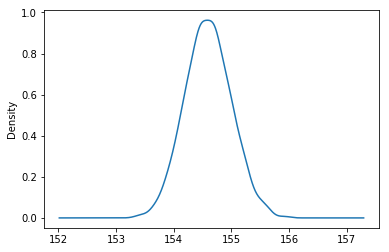

In [52]:
trace_df['mu'].plot.density();

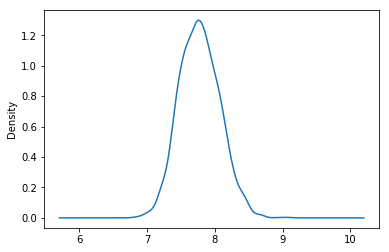

In [53]:
trace_df['sigma'].plot.density();

* **overthinking: under the hood with multivariate sampling** posterior samples of quadratix approximation taken from multivariate normal distribution. like this:

In [57]:
# Code 4.34
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10)

array([[154.573164  ,   7.32839202],
       [154.45030795,   8.37125676],
       [155.04624746,   7.74737568],
       [153.97422913,   7.71796723],
       [154.36542258,   7.79901329],
       [154.37474763,   7.72417743],
       [154.64092657,   8.13386869],
       [154.19441888,   7.96907941],
       [155.09660359,   7.83126281],
       [154.72149806,   7.2383024 ]])

* **overthinking: getting sigma right** quadratic assumption for sigma can be problematic. can help to estimate log(sigma) instead. why is this helpful? distribution of log(sigma) much more often gaussian than distribution of sigma. done in the following code:
* (note that pymc3 translation diverges again. in book: model through normal, exponentiate log_sigma, and give prior to log_sigma. in pymc3: use lognormal instead)

In [58]:
# Code 4.35 and Code 4.36
with pm.Model() as m4_1_logsigma:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Lognormal('sigma', mu=2, tau=0.01)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1_logsigma = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 861.02draws/s] 
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


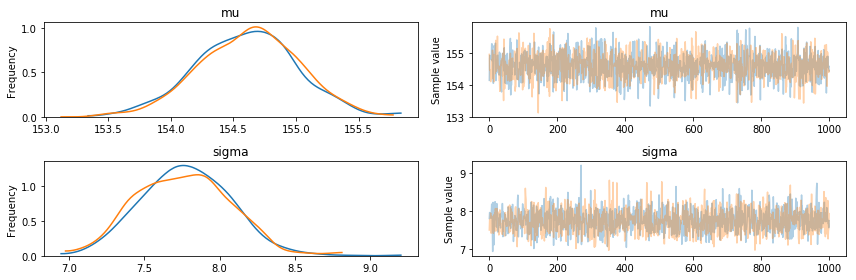

In [59]:
pm.traceplot(trace_4_1_logsigma);

## 4.4. Adding a predictor

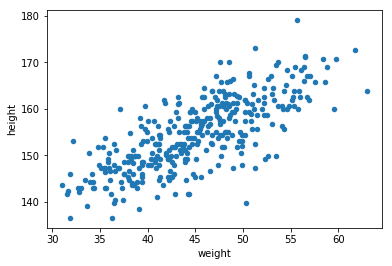

In [62]:
# Code 4.37
d2.plot.scatter(x='weight', y='height');

* **rethinking: what is "regression"?** many types of models called "regression". by now term means "using one or more predictor variables to model distribution of one or more outcome variables" (so general it's nearly meaningless). term originally due to Francis Galton. he observed: sons of tall or short men tend to be closer to population mean, thus "regression to the mean". McElreath writes "this penomenon arises statistically whnever individual measurements are assigned a common distribution, leading to shrinkage as each measurement informs the others". Unclear what he means by this. Discuss.

### 4.4.1. The linear model strategy
* **linear model** = make parameter for mean of gaussian, i.e. \mu, into linear function of predictor variables and other parameters which can be made up by the modeller
* model assumes constant, additive relationship of predictor to mean of outcome
* model computes posterior distribution of this relationship (direction and strength)
* fitting model = finding relative plausibility of all parameter combinations given data
* some of these parameters now refer to the strength of (linear, constant) relationship between predictor and mean of outcome

##### 4.4.1.1. Likelihood
* lhood - gives plausibility for each data point, now assumes a separate gaussian per datum with mean given by linear model and variance shared across all of these distributions

#### 4.4.1.2. linear model
* \mu no longer parameter. also not stochastic anymore. instead, deterministic given \alpha, \beta and x_i. creates linear combination of these, with \alpha = intercept, \beta = change in mean height for 1 unit change in weight and x_i weight for datum i
* \alpha and \beta are 'made up' by us. will make up many more parameters as models develop
* 'model is good at finding best-fitting values for line defined by \alpha and \beta, but it is up to modeller to decide if that is a useful question'
* **rethinking: nothing special or natural about linear models**. any sort of relationship between \alpha, \beta and \mu possible, does not have to be linear one, e.g. \mu_i = \alpha * exp(-\beta * x_i). Not linear regression, but still regression. Linear is conventional, not required. Can e.g. use relationship based on theory.
* **overthinking: units and regression models.** carrying units shows that \beta needs to be rate of change. 

#### 4.4.1.3. priors
* chosen priors are weak, will lead to similar outcome as maximum likelihood
* best approach is to play around with priors, plot them, re-fit model, plot posterior, see impact
* prior for \beta is 0-centered gaussian with high variance. effect: pulls \beta towards 0, but only a bit. makes model inference more conversative (=regularization), but still just a bit. also silly: don't really expect negative association between weight and height to be as likely as positive one. does not hurt here, but can be done much better
* **rethinking: what is the correct prior?** there's no one correct prior just like there's no one correct likelihood. "statistical models are machines for inference. many machines will work, but some work better than others. priors can be wrong, but only in the sense that a kind of hammer can be wrong for building a table". priors = state of information before seeing data. can be used to explore results of starting from different information. can be used to encode what we know. it's a folly to think that a default procedure that does not require a modeller's choice, e.g. for priors, is more objective. that would mean that everyone doing the same thing makes something objective. it doesn't actually give guarantees for accordance with reality

### 4.4.2. fitting the model
* same as before, just using new definitions and parameters
* the pymc3 adaption is going for mcmc instead of map again. using their code

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:11<00:00, 355.07draws/s]
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


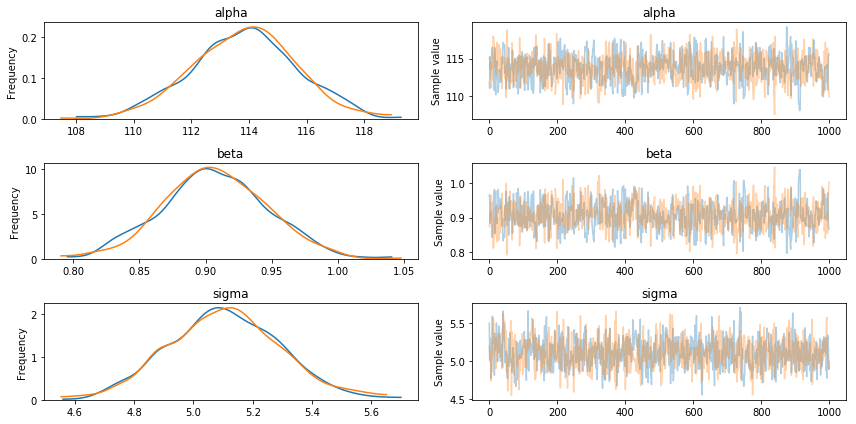

In [64]:
# Code 4.38 and Code 4.39
with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_3 = pm.sample(1000, tune=1000)

pm.traceplot(trace_4_3);

* **rethinking: everything that depens upon parameters has a posterior distribution.** \mu no longer parameter b/c deterministic function of params \alpha and \beta. however, b/c there's uncertainty around \alpha and \beta there's uncertainty around \mu even though it is not a parameter anymore. params are uncertain -> everything that depends on them is also uncertain. (side: \mu is now a statistic). this is true for statistics, predictions, fit measures and everything else depending on params. how to deal with this? when using samples of joint posterior: calculate whatever statistic/measure for each sample. then automatically the computed values will approximate the statistics/measures/... posterior distribution.
* **overthinking: embedding linear models** can also specifiy model like this, might help to understand: height ~ dnorm( a + b*weight , sigma )

### 4.4.3. interpreting the model fit
* stat models can be hard to interpret. can only give posterior probabilities. those answer question which is posed by this combination of model and data. however, it's modeller's responsibility to make sense of this answer
* 2 ways of handling model output: read tables, or plot. Plotting very much recommended, especially for more complicated models. Once familiarity has been built through plotting reading tables might be enough, but just because of what has been learned before.
* through plotting can learn 1) if model fitting worked, 2) absolute, rather than relative, magnitude of outcome/predictor relationship, 3) uncertainty around avg relationship, and 5) uncertainty around model predictions
* also, importantly: once comfortable w/ plotting: can ask any question of any model
* **rethinking: what do parameters mean?** no consensus about what parameters mean, depend on people's beliefs about models, probability, and prediction. this book has typical bayesian stance: "posterior probabilities of parameter values describe the relative compatibility of different states of the world with the data, according to the model". all these numbers model-internal. might be disagreement about real-world meaning. usful, b/c these disagreements can lead to model criticism and revision, which models can't do for us.

##### 4.4.3.1. tables of estimates

In [65]:
# Code 4.40
pm.summary(trace_4_3, alpha=.11).round(2)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,113.81,1.80,0.06,110.88,116.62,765.39,1.0
beta,0.91,0.04,0.00,0.85,0.97,734.64,1.0
sigma,5.10,0.19,0.01,4.83,5.42,769.25,1.0


* \beta can be read as 'a person 1kg heavier is expected to be 0.91 cm taller'. hdpi tells us that plausible values given data and model for \beta are almost certainly greater than 0 and not much greater than 1. 
* **all of this is conditional on the model**. all outcomes are to be read: "assumming the model is true and given the data: ...". 
* for different model \beta might be different
* \alpha parameter tells us person should be 114cm tall if weighing 0 kg. nonsense b/c people have weight. but also true: this is what to expect when all parameters are 0. thus: intercept parameters often impossible to interpret without studying any \beta parameters
* also need to study variance/covariance to understand fitted model

In [67]:
# Code 4.41
trace_df = pm.trace_to_dataframe(trace_4_3)
trace_df.corr().round(2)

,alpha,beta,sigma
alpha,1.00,-0.99,0.04
beta,-0.99,1.00,-0.04
sigma,0.04,-0.04,1.00


* strong (negative) correlation between \alpha and \beta: these parameters carry almost exactly the same information. (here: if intercept changes, best slope changes to match it and vice versa). strong correlations can make it difficult to fit model to data, set up model so this does not happen
* technique to do this: **centering**, i.e. subtract mean of variable from all values

In [71]:
# Code 4.42
d2 = d2.assign(weight_c=d2.weight - d2.weight.mean())
d2.weight_c.mean()

8.276208001751166e-16

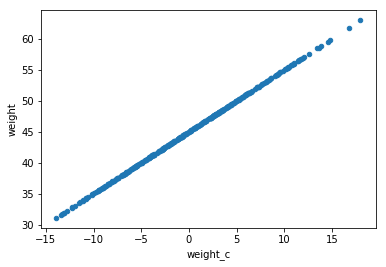

In [72]:
d2.plot.scatter(x='weight_c', y='weight');

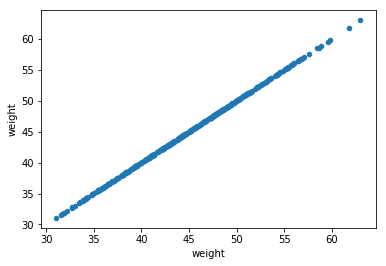

In [73]:
d2.plot.scatter(x='weight', y='weight');

In [74]:
# Code 4.43
with pm.Model() as m4_4:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight_c
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1167.00draws/s]
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [75]:
# Code 4.44
pm.summary(trace_4_4, alpha=.11).round(2)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,154.6,0.28,0.01,154.14,155.04,3277.84,1.0
beta,0.9,0.04,0.00,0.84,0.98,2822.30,1.0
sigma,5.1,0.19,0.00,4.78,5.38,2832.47,1.0


In [77]:
d2.height.mean()

154.5970926136364

In [78]:
trace_df = pm.trace_to_dataframe(trace_4_4)
trace_df.corr().round(2)

,alpha,beta,sigma
alpha,1.00,-0.00,0.03
beta,-0.00,1.00,-0.02
sigma,0.03,-0.02,1.00


* beta+sigma unchanged. alpha now equal to mean value of un-centered (original) weights. correlations are 0.
* interpretation of alpha still is 'expected value of outcome variable if predictor is 0'. but now mean of predictor is 0. thus: expected value of outcome when predictor is at its average value. makes interpretation of intercept easier.

#### 4.4.3.2. plotting posterior inference against the data
* pymc3 uses mean of posterior instead of map

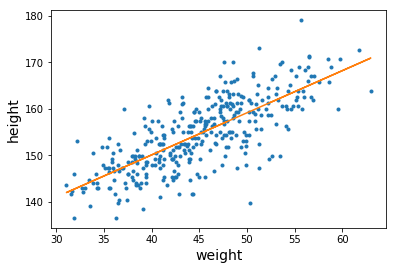

In [82]:
# Code 4.45
plt.plot(d2.weight, d2.height, '.')
plt.plot(d2.weight, trace_4_3['alpha'].mean() + trace_4_3['beta'].mean() * d2.weight)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14);

#### 4.4.3.3. adding uncertainty around the mean
* thus far only looking MAP
* however, posterior defines lots of alpha/beta combinations and their probabilities, all of which define lines. let's use that information

In [83]:
# Code 4.46 and Code 4.47
pm.trace_to_dataframe(trace_4_4)[:5]

,alpha,beta,sigma
0,153.982734,0.898784,5.042502
1,154.012833,0.934708,5.138103
2,155.160899,0.872897,5.038042
3,154.342487,0.923975,5.099776
4,154.629742,0.883204,5.078818


* average of the above will give mean line
* scatter around that informative as it can change our confidence in relationship between predictor and outcome

In [104]:
# Code 4.48
N = [10, 50, 150, 352][3]
with pm.Model() as m_N:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight[:N])
    height_hat = pm.Normal('height_hat', mu=mu, sd=sigma, observed=d2.height[:N])
    trace_N = pm.sample(1000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 418.15draws/s]


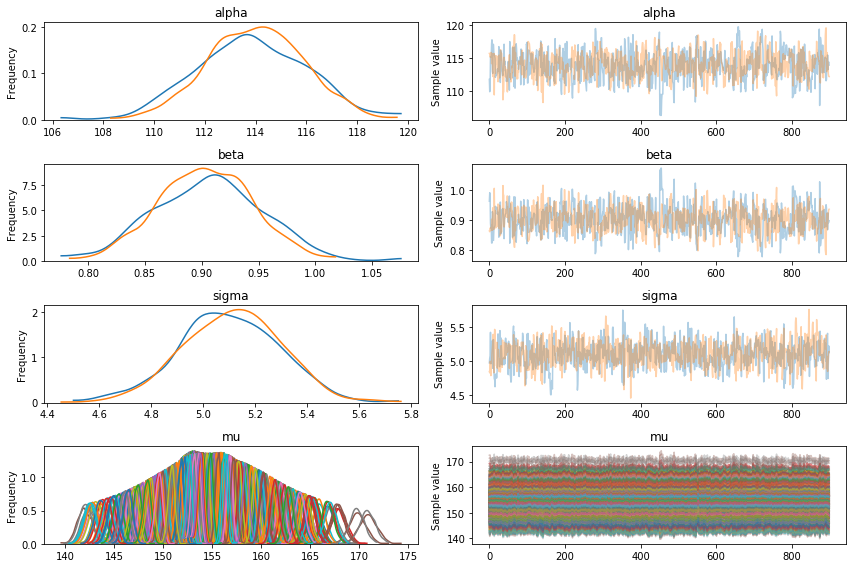

In [105]:
chain_N = trace_N[100:]
pm.traceplot(chain_N);

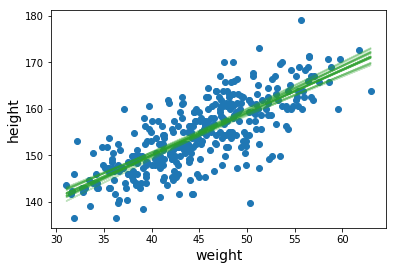

In [106]:
# Code 4.49
plt.plot(d2.weight[:N], d2.height[:N], 'C0o')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(d2.weight[:N], chain_N['alpha'][idx] + chain_N['beta'][idx] * d2.weight[:N], 'C2-', alpha=0.3)
plt.xlabel(d2.columns[1], fontsize=14)
plt.ylabel(d2.columns[0], fontsize=14);

#### 4.4.3.4. Plotting regression intervals and contours

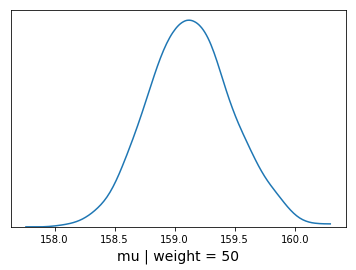

In [107]:
# Code 4.50 and 4.51
mu_at_50 = chain_N['alpha'] + chain_N['beta'] * 50
pm.kdeplot(mu_at_50)
plt.xlabel('mu | weight = 50', fontsize=14)
plt.yticks([]);

In [108]:
# Code 4.52
pm.hpd(mu_at_50, alpha=.11)

array([158.5514242 , 159.65170843])

* pymc3 diverges from the book: "Using PyMC3, we do not need to compute anything else. By defining a deterministic variable mu in the model, we add that variable to the trace. Thus we get a matrix with row samples from the posterior and columns values of weights. We can access this matrix directly from the trace or turn it into a DataFrame, it all depends on what we need."

In [109]:
# Code 4.53
df_trace_N = pm.trace_to_dataframe(chain_N).filter(regex=('mu.*'))
df_trace_N.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,...,mu__342,mu__343,mu__344,mu__345,mu__346,mu__347,mu__348,mu__349,mu__350,mu__351
0,157.869138,146.942366,142.489707,162.895453,151.558927,172.483695,148.636016,165.244709,145.385301,164.288616,...,154.208669,157.923772,149.756010,151.340392,151.121856,157.104264,144.784329,162.048628,163.878862,162.403748
1,157.388150,146.134152,141.548148,162.564988,150.888966,172.440371,147.878522,164.984598,144.530458,163.999873,...,153.618061,157.444420,149.032057,150.663886,150.438806,156.600370,143.911488,161.692804,163.577848,162.058558
2,157.667876,146.526134,141.985874,162.793078,151.233520,172.569957,148.253104,165.188553,144.938435,164.213650,...,153.935392,157.723585,149.395132,151.010685,150.787850,156.887954,144.325639,161.929593,163.795835,162.291699
3,157.757477,147.673080,143.563688,162.396300,151.933738,171.245358,149.236162,164.564445,146.236053,163.682061,...,154.379204,157.807899,150.269812,151.732050,151.530362,157.051569,145.681412,161.614759,163.303896,161.942502
4,156.904261,146.998275,142.961585,161.461014,151.183554,170.153517,148.533703,163.590801,145.586672,162.724027,...,153.585755,156.953791,149.549066,150.985434,150.787314,156.210842,145.041842,160.693300,162.352553,161.015245


* pymc3 divergence for next code: "We are doing manually, what in thebook is done using the link function. In the book on code 4.58 the following operations are performed manually"

In [111]:
# Code 4.54 and Code 4.58
weigth_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
chain_N_thinned = chain_N[::10]
mu_pred = np.zeros((len(weigth_seq), len(chain_N_thinned)*chain_N.nchains))
for i, w in enumerate(weigth_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + chain_N_thinned['beta'] * w

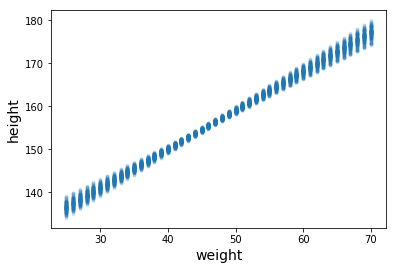

In [117]:
# Code 4.55
plt.plot(weigth_seq, mu_pred, 'C0.', alpha=0.1)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14);

In [124]:
mu_pred.shape

(46, 180)

In [141]:
# Code 4.56
mu_mean = mu_pred.mean(axis=1)
mu_hpd = pm.hpd(mu_pred.T, alpha=.11)

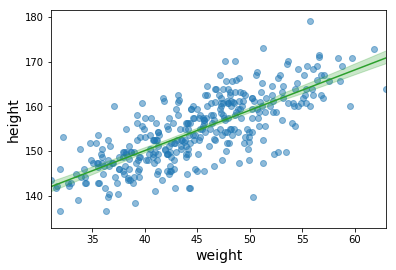

In [145]:
# Code 4.57
plt.scatter(d2.weight[:N], d2.height[:N], alpha=.5)
plt.plot(weigth_seq, mu_mean, 'C2')
plt.fill_between(weigth_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)

plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

* use this pseud-empirical approach w/ samples instead of mathematics b/c 1) easier, quicker to learn. maybe not as elegant, but super useful. 2) once mcmc is used, this is the only thing that can be done, so worth learning anyway
* summary: how to generate predictions and intervals from posterior of fit model. 1) choose a range of predictor values to investigate. generate samples from model posterior. for each sample of posterior, for each predictor value generate a \mu value. this creates a distribution of \mu values for each predictor value. 2) summarize distribution of \mu values for each value of predictor variable by using mean, hdpi, mode, ... 3) Plot, e.g. using lines and shades. Also room to be more creative and ask more interesting questions about model.
* **rethinking: overconfident model intervals.*** in previous plot: little uncertainty about mean of height given weight. **but: inferences always conditional on model. assuming model is correct, this is inference you get with these data. even terrible model can be very confident. translate regression lines as: "conditional on the assumption that height and weight are related by a straight line then this is the most plausible line and there are its plausible bounds.**

#### 4.4.3.5. prediction intervals
* to generate prediction intervals for heights, not just for means of heights, need to also incorporate \sigma and its uncertainty
* recipe: for each weight, sample values for \mu (or rather: \alpha and \beta), as well as \sigma from posterior. each joint posterior sample defines gaussian. take sample from that likelihood. overall gives distribution of heights for each weight, taking into account uncertainty around all parameters as well as their covariance, as well as uncertainty in the Gaussian likelihood
* **pymc diverges**: "Now we are going to use sample_ppc() from PyCM3. This function give us posterior predictive samples, that is for each value of the input variable we get the a sample (from the posterior) of the output variable. Thus in the following example the shape of height_pred['height_hat'].shape is (200, 352)"

In [146]:
# Code 4.59
height_pred = pm.sample_ppc(chain_N, 200, m_N)

100%|██████████| 200/200 [00:01<00:00, 106.68it/s]


In [151]:
# Code 4.60
height_pred_hpd = pm.hpd(height_pred['height_hat'])

In [160]:
height_pred_hpd.shape

(352, 2)

In [161]:
weigth_seq.shape

(46,)

In [164]:
# pymc divergence bla bla
idx = np.argsort(d2.weight.values[:N])
d2_weight_ord = d2.weight.values[:N][idx]
height_pred_hpd = height_pred_hpd[idx]

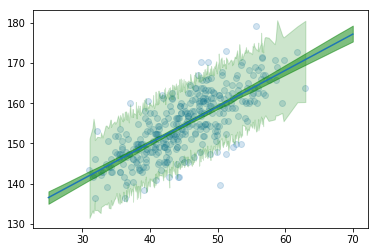

In [169]:
# Code 4.61
# raw data
plt.scatter(d2.weight, d2.height, alpha=.2);

# MAP line
plt.plot(weigth_seq, mu_mean);

# hpdi region for line
plt.fill_between(weigth_seq, mu_hpd[:,1], mu_hpd[:,0], alpha=.5, color='green');

# hpdi region for heights
plt.fill_between(d2_weight_ord, height_pred_hpd[:, 1], height_pred_hpd[:, 0], alpha=.2, color='green');

In [170]:
# Code 4.62
# skipped, can re-run earlier code with other value for N

* **rethinkinking: two kinds of uncertainty** uncertainty in 1) parameters and 2) sampling process. distinct even though processed in similar way and blended together in posterior predictive simulation. posterior distribution = ranking of relative plausibilities of combinations of parameter values. distribution of simulated outcomes (here: heights) is instead distribution including sampling variation of some Gaussian process. this sampling variation is also a model assumption. same amount of (non-)objectivity as posterior distribution. important not to confuse two kinds of uncertainty, as they are based on different model assumptions. also: possible to see assumption of gaussian not to predict future values (ontological) but only to understand mean/variance of past data (epistemological). if the latter, then it might not make sense to simulate outcomes.

In [171]:
# Code 4.63
# skipped, R internals

## 4.5. Polynomial regression

In [178]:
# Code 4.64
d = pd.read_csv('./data/Howell1.csv', sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


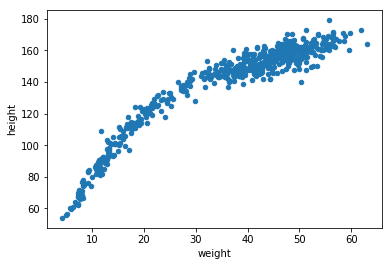

In [179]:
d.plot.scatter(x='weight', y='height');

* this is visibly curved. in this section: model this relationship through **polynomial regression**
* 'polynomial' here = equation for \mu_i has terms wtih squares, cubes etc in it
* however, still only one predictor, thus bivariate regression
* **generally bad idea to use polynomial regression b/c polynomials are hard to interpret. better: have mechanism of data generation that builds non-linear relationship from the ground up. look for exercises of this chapter to see this**
* $\mu_i = \alpha + \beta_1 x_i + \beta_2 x_i^2$
* **rethinking: linear, additive, funky.** model for $\mu_i$ above still called 'linear'. 'linear' means different things depending on context, or even different things within one context. function of $\mu_i$ not a line anymore. however, it is a **linear function of each individual parameter**. Easy to fit, easier to interpet as all parameters affect mean independently. Disadvantage: used by convention, thoughtlessly. Can often be outperformed if actual insight of domain is used to model things differently. **should feel embarrased to use them so we don't become satisfied with default/thoughtless approach**
* **fitting these models to data is easy. interpretation can be hard**
* when fitting: **standardize**, i.e. center variable and then divide by std dev. result: move mean to zero, rescale range of data. reasons: 
  * interpretability: for stdized var: change of one unit = change of one std dev. can be more interesting than one unit change in natural scale. makes it easier to compare relative influence of variables once there are many, especially on different scales. however, sometimes also makes interpretation harder, might want to see effect of unit change in natural scale. can convert back and forth.
  * model fitting advantages: very large/small numbers can lead to numerical issues. in particular when using cubes or higher orders, as numbers tend to blow up. standardizing mostly resolves this.
* 

In [210]:
# Code 4.65
d['weight_std'] = (d.weight - d.weight.mean()) / d.weight.std()

print(d.weight_std.mean())
print(d.weight_std.std())

1.3061447348531253e-17
0.9999999999999998


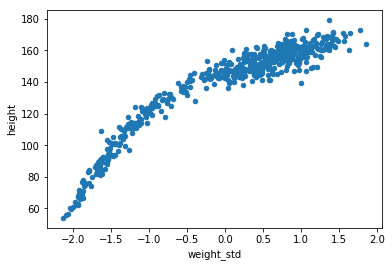

In [211]:
d.plot.scatter(x='weight_std', y='height');

* no information has been lost, same relationship, but different X axis

In [217]:
# Code 4.66
d['weight_std2'] = d.weight_std ** 2

with pm.Model() as m_4_5:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    mu = pm.Deterministic(
        'mu', 
        alpha + beta[0] * d.weight_s + beta[1] * d.weight_s2
    )
    
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    
    trace_4_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 689.07draws/s]


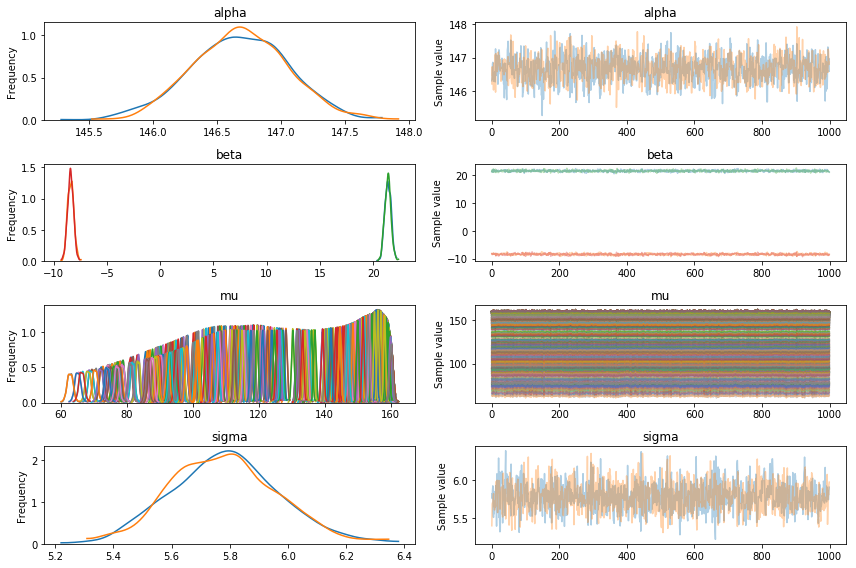

In [218]:
pm.traceplot(trace_4_5);

In [219]:
pm.summary(trace_4_5)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,146.674026,0.369344,0.009567,145.943090,147.376546,1154.607070,1.000076
beta__0,21.384344,0.293239,0.006273,20.804293,21.929030,1536.339012,0.999901
beta__1,-8.424314,0.281859,0.007461,-8.974237,-7.892544,1036.433407,1.000351
mu__0,158.618552,0.326332,0.006653,158.014095,159.290045,2344.164864,0.999526
mu__1,147.915737,0.362198,0.009366,147.199424,148.597485,1175.177975,1.000049
mu__2,140.686504,0.390186,0.010017,139.871185,141.396380,1121.484577,1.000135
mu__3,160.183783,0.490807,0.010489,159.232186,161.120398,1639.579465,0.999883
mu__4,153.657668,0.317018,0.007800,153.048151,154.261512,1462.632651,0.999789
mu__5,157.301240,1.119563,0.027085,155.242090,159.482607,1171.127780,1.000242
mu__6,150.229561,0.346026,0.008869,149.538588,150.866368,1238.521371,0.999977


In [220]:
# wow, that output before was a lot...
pm.summary(trace_4_5, varnames=['alpha', 'beta', 'sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,146.674026,0.369344,0.009567,145.943090,147.376546,1154.607070,1.000076
beta__0,21.384344,0.293239,0.006273,20.804293,21.929030,1536.339012,0.999901
beta__1,-8.424314,0.281859,0.007461,-8.974237,-7.892544,1036.433407,1.000351
sigma,5.782517,0.183745,0.004660,5.398250,6.118112,1617.020147,0.999646


* $\alpha$ still intercept but hard to interpret. no longer mean of height in sample, not guaranteed in polynomial regression. 
* $\beta_1$ and $\beta_2$ are linear and square components of curve, but hard to interpret
* needs plotting to understand what model says
* **pymc code diverges from book for the following blocks, using pymc version**

In [223]:
# Code 4.68
mu_pred = trace_4_5['mu']
idx = np.argsort(d.weight_std)
mu_hpd = pm.hpd(mu_pred, alpha=.11)[idx]

height_pred = pm.sample_ppc(trace_4_5, 200, m_4_5)
height_pred_hpd = pm.hpd(height_pred['height'], alpha=.11)[idx]

100%|██████████| 200/200 [00:00<00:00, 684.51it/s]


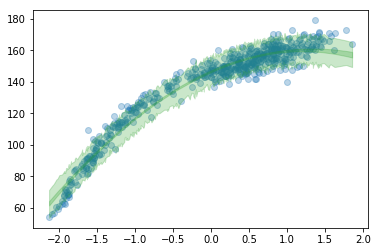

In [226]:
# Code 4.69
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);
plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 415.23draws/s]


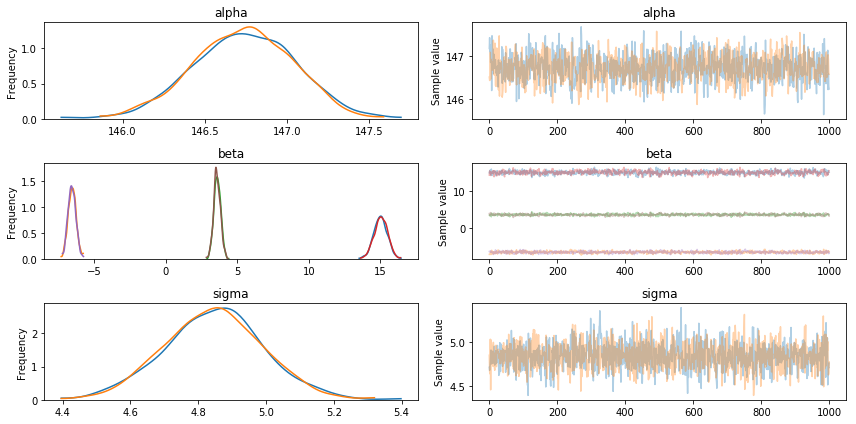

In [228]:
# Code 4.70
weight_m = np.vstack((d.weight_std, d.weight_std**2, d.weight_std**3))

with pm.Model() as m_4_6:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + pm.math.dot(beta, weight_m))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)

    trace_4_6 = pm.sample(1000, tune=1000)

pm.traceplot(trace_4_6, ['alpha', 'beta', 'sigma']);

100%|██████████| 200/200 [00:00<00:00, 617.15it/s]


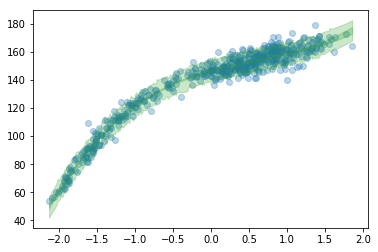

In [229]:
mu_pred = trace_4_6['mu']
idx = np.argsort(d.weight_std)
mu_hpd = pm.hpd(mu_pred, alpha=.11)[idx]

height_pred = pm.sample_ppc(trace_4_6, 200, m_4_6)
height_pred_hpd = pm.hpd(height_pred['height'], alpha=.11)[idx]

plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);
plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25);

* observations:
  * parabolic ($x_i^2$) model fits data a lot better than first-order model
  * cubic/third order ($x_i^3$) model fits data even better than parabolic one. fewer points outside of curve.
* however: not obvious that these models make any sense. good conventionalized descriptions of sample, not necessarily more. later chapters will investigate how a better fitting model is not necessarily a better one
* **overthinking: converting back to natural scale**. above plots have standardized units, also called **z-scores** on X-axis. if wanting to go back, this is how conversion is done:

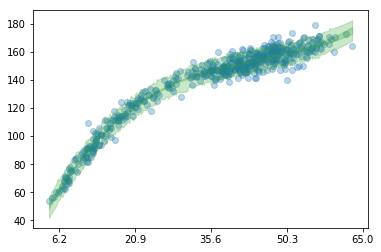

In [230]:
# Code 4.71 and Code 4.72
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);
plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25)

at = np.arange(-2, 3)
plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(), 1));

* **note: these are literally the same operations just backwards. first multiply with std dev of original data, then add the original mean**

## 4.6. Summary
* Intro to linear regression model: method of estimating association between predictor and outcome variable
* linear regression models use Gaussian distribution as likelihood as Gaussian counts relative number of ways (plausibilites) in which different means/std devs can produce observed data
* uses MAP estimation to fit model (**note: in book only, pymc3 code used mcmc from the start**)
* showed techniques for visualizing posterior distrbutions and posterior predictions
* next chapter: regression models with more than one predictor variable

## 4.7. Practice

**Easy**

### 4E1.